## Figure: Learning efficiency

## Set up

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "pirnns"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/pirnns/pirnns
Directory added to path:  /home/facosta/pirnns
Directory added to path:  /home/facosta/pirnns/pirnns


## Load all the trained models

In [8]:
from pirnns.paper_figs.load_models import load_experiment_sweep
import torch


sweep_dir = (
    "/home/facosta/pirnns/pirnns/logs/experiments/timescales_sweep_20250924_144313"
)

device = "cuda" if torch.cuda.is_available() else "cpu"

models, metadata, summary = load_experiment_sweep(
    sweep_dir=sweep_dir,
    device=device,
    use_lightning_checkpoint=True,
    checkpoint_type="best",
)

print("\nLoaded experiments:")
for exp_name, seeds in models.items():
    print(f"  {exp_name}: {len(seeds)} seeds")

    # Show timescales config for this experiment
    sample_config = list(seeds.values())[0]["config"]
    timescales_config = sample_config["timescales_config"]
    print(f"    Timescales config: {timescales_config}")

    # Show validation loss stats
    val_losses = [seed_data["final_val_loss"] for seed_data in seeds.values()]
    print(f"    Val loss range: {min(val_losses):.4f} - {max(val_losses):.4f}")

    # Show training data availability
    training_data_count = sum(
        1 for seed_data in seeds.values() if seed_data["training_losses"]
    )
    print(f"    Training curves available: {training_data_count}/{len(seeds)} seeds")
    print()

Loading 8 experiments with 1 seeds each...
Total models to load: 8
Using Lightning checkpoints

Loading experiment: discrete_single_025
  ✓ Loaded discrete_single_025/seed_0
Loading experiment: discrete_single_05
  ✓ Loaded discrete_single_05/seed_0
Loading experiment: discrete_single_075
  ✓ Loaded discrete_single_075/seed_0
Loading experiment: discrete_single_1
  ✓ Loaded discrete_single_1/seed_0
Loading experiment: discrete_two
  ✓ Loaded discrete_two/seed_0
Loading experiment: discrete_four
  ✓ Loaded discrete_four/seed_0
Loading experiment: continuous_powerlaw_20
  ✓ Loaded continuous_powerlaw_20/seed_0
Loading experiment: continuous_powerlaw_15
  ✓ Loaded continuous_powerlaw_15/seed_0

Successfully loaded: 8/8 models

Loaded experiments:
  discrete_single_025: 1 seeds
    Timescales config: {'type': 'discrete', 'values': [0.3476]}
    Val loss range: 6.1007 - 6.1007
    Training curves available: 1/1 seeds

  discrete_single_05: 1 seeds
    Timescales config: {'type': 'discrete',

discrete_single_025: 1 seeds, final train loss = 6.1011 ± 0.0000
discrete_single_05: 1 seeds, final train loss = 6.0708 ± 0.0000
discrete_single_075: 1 seeds, final train loss = 6.0599 ± 0.0000
discrete_single_1: 1 seeds, final train loss = 6.0579 ± 0.0000
discrete_two: 1 seeds, final train loss = 6.0639 ± 0.0000
discrete_four: 1 seeds, final train loss = 6.0589 ± 0.0000
continuous_powerlaw_20: 1 seeds, final train loss = 6.0600 ± 0.0000
continuous_powerlaw_15: 1 seeds, final train loss = 6.0621 ± 0.0000


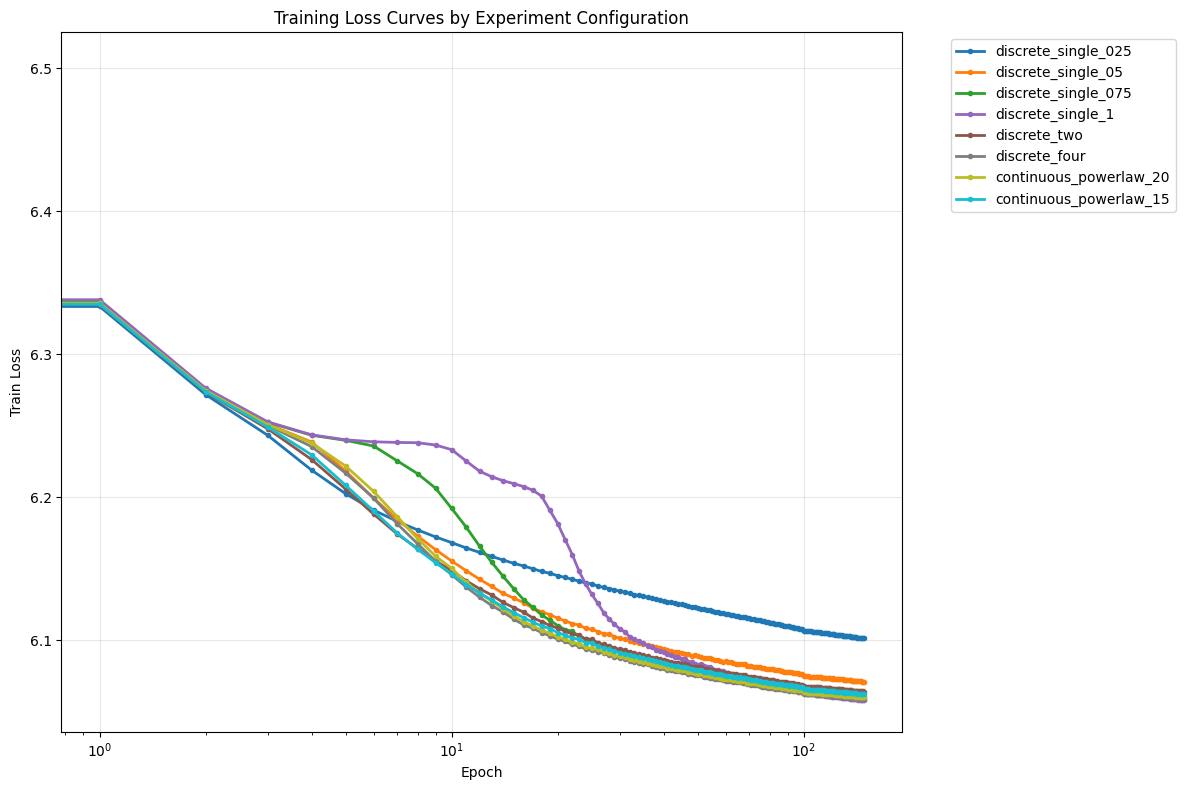

discrete_single_025: 1 seeds, final val loss = 6.1011 ± 0.0000
discrete_single_05: 1 seeds, final val loss = 6.0703 ± 0.0000
discrete_single_075: 1 seeds, final val loss = 6.0594 ± 0.0000
discrete_single_1: 1 seeds, final val loss = 6.0575 ± 0.0000
discrete_two: 1 seeds, final val loss = 6.0634 ± 0.0000
discrete_four: 1 seeds, final val loss = 6.0585 ± 0.0000
continuous_powerlaw_20: 1 seeds, final val loss = 6.0595 ± 0.0000
continuous_powerlaw_15: 1 seeds, final val loss = 6.0616 ± 0.0000


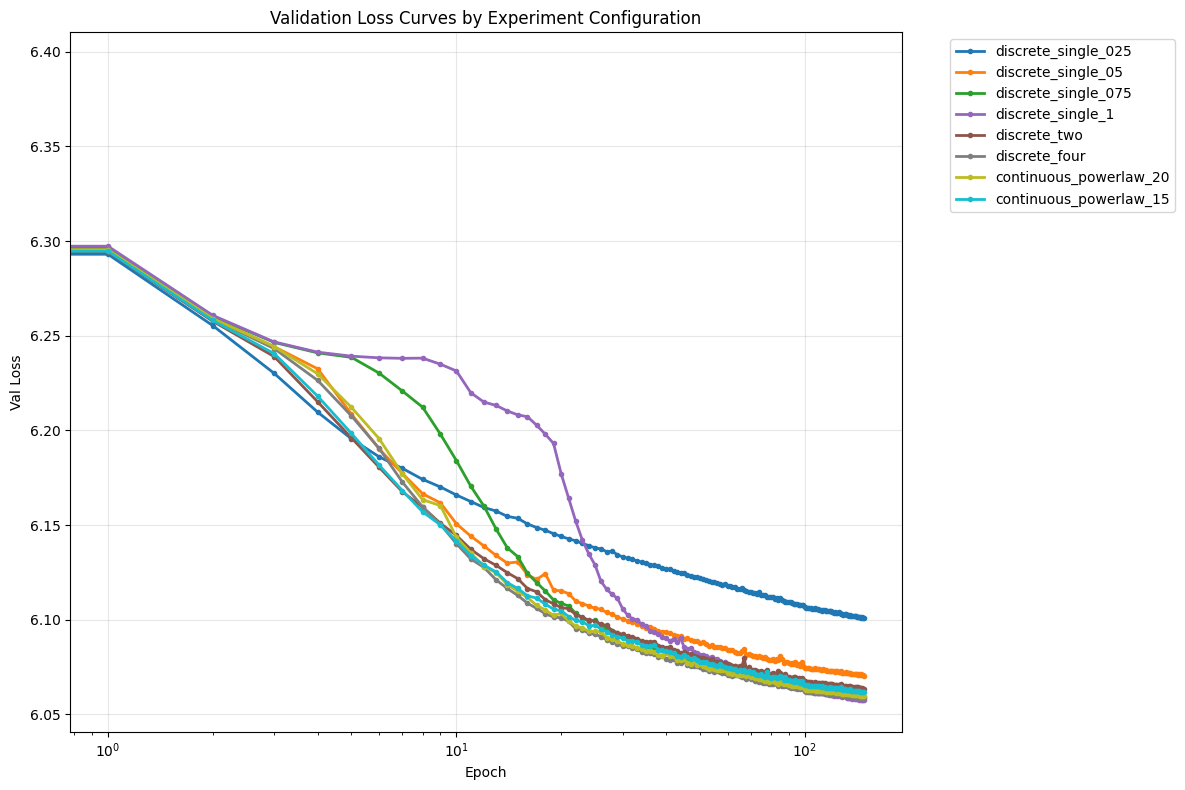

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any


def plot_loss_curves_by_experiment(
    models: Dict[str, Dict[int, Dict[str, Any]]],
    loss_type: str = "train",  # "train" or "val"
    figsize: tuple = (12, 8),
    title: str = None,
    log_x: bool = True,
    log_y: bool = True,
    alpha_fill: float = 0.3,
) -> None:
    """
    Plot mean training/validation loss curves across seeds for each experiment.

    Args:
        models: Dictionary from load_experiment_sweep
        loss_type: "train" or "val"
        figsize: Figure size
        title: Plot title (auto-generated if None)
        log_x: Use log scale on x-axis
        log_y: Use log scale on y-axis
        alpha_fill: Transparency for error bars
    """

    plt.figure(figsize=figsize)

    # Color palette for experiments
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

    for exp_idx, (exp_name, seeds) in enumerate(models.items()):
        # Collect loss curves from all seeds
        all_losses = []
        all_epochs = []

        for seed, seed_data in seeds.items():
            training_losses = seed_data["training_losses"]
            if not training_losses:  # Skip if no training data
                continue

            epochs = np.array(training_losses["epochs"])
            if loss_type == "train":
                losses = np.array(training_losses["train_losses"])
            else:  # val
                losses = np.array(training_losses["val_losses"])

            all_losses.append(losses)
            all_epochs.append(epochs)

        if not all_losses:
            print(f"Warning: No training data found for experiment {exp_name}")
            continue

        # Find common epoch range (in case different seeds have different lengths)
        min_length = min(len(losses) for losses in all_losses)

        # Truncate all arrays to common length
        all_losses = [losses[:min_length] for losses in all_losses]
        epochs = all_epochs[0][:min_length]  # Use epochs from first seed

        # Convert to numpy array and compute statistics
        losses_array = np.array(all_losses)  # Shape: (n_seeds, n_epochs)

        mean_losses = np.mean(losses_array, axis=0)
        std_losses = np.std(losses_array, axis=0)

        # Plot mean with error bars
        color = colors[exp_idx]
        plt.plot(
            epochs,
            mean_losses,
            "o-",
            color=color,
            label=exp_name,
            linewidth=2,
            markersize=3,
        )
        plt.fill_between(
            epochs,
            mean_losses - std_losses,
            mean_losses + std_losses,
            alpha=alpha_fill,
            color=color,
        )

        print(
            f"{exp_name}: {len(all_losses)} seeds, final {loss_type} loss = {mean_losses[-1]:.4f} ± {std_losses[-1]:.4f}"
        )

    plt.xlabel("Epoch")
    plt.ylabel(f"{loss_type.capitalize()} Loss")

    if title is None:
        title = f"{loss_type.capitalize()} Loss Curves by Experiment (Mean ± Std across seeds)"
    plt.title(title)

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)

    # Apply log scales
    if log_y:
        plt.yscale("log")
    if log_x:
        plt.xscale("log")

    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Plot training loss curves
plot_loss_curves_by_experiment(
    models,
    loss_type="train",
    title="Training Loss Curves by Experiment Configuration",
    log_x=True,
    log_y=False,
)

# Plot validation loss curves
plot_loss_curves_by_experiment(
    models,
    loss_type="val",
    title="Validation Loss Curves by Experiment Configuration",
    log_x=True,
    log_y=False,
)

discrete_single_025: 1 seeds, final decoding error = 0.0770 ± 0.0000
discrete_single_05: 1 seeds, final decoding error = 0.0589 ± 0.0000
discrete_single_075: 1 seeds, final decoding error = 0.0542 ± 0.0000
discrete_single_1: 1 seeds, final decoding error = 0.0542 ± 0.0000
discrete_two: 1 seeds, final decoding error = 0.0568 ± 0.0000
discrete_four: 1 seeds, final decoding error = 0.0550 ± 0.0000
continuous_powerlaw_20: 1 seeds, final decoding error = 0.0550 ± 0.0000
continuous_powerlaw_15: 1 seeds, final decoding error = 0.0564 ± 0.0000


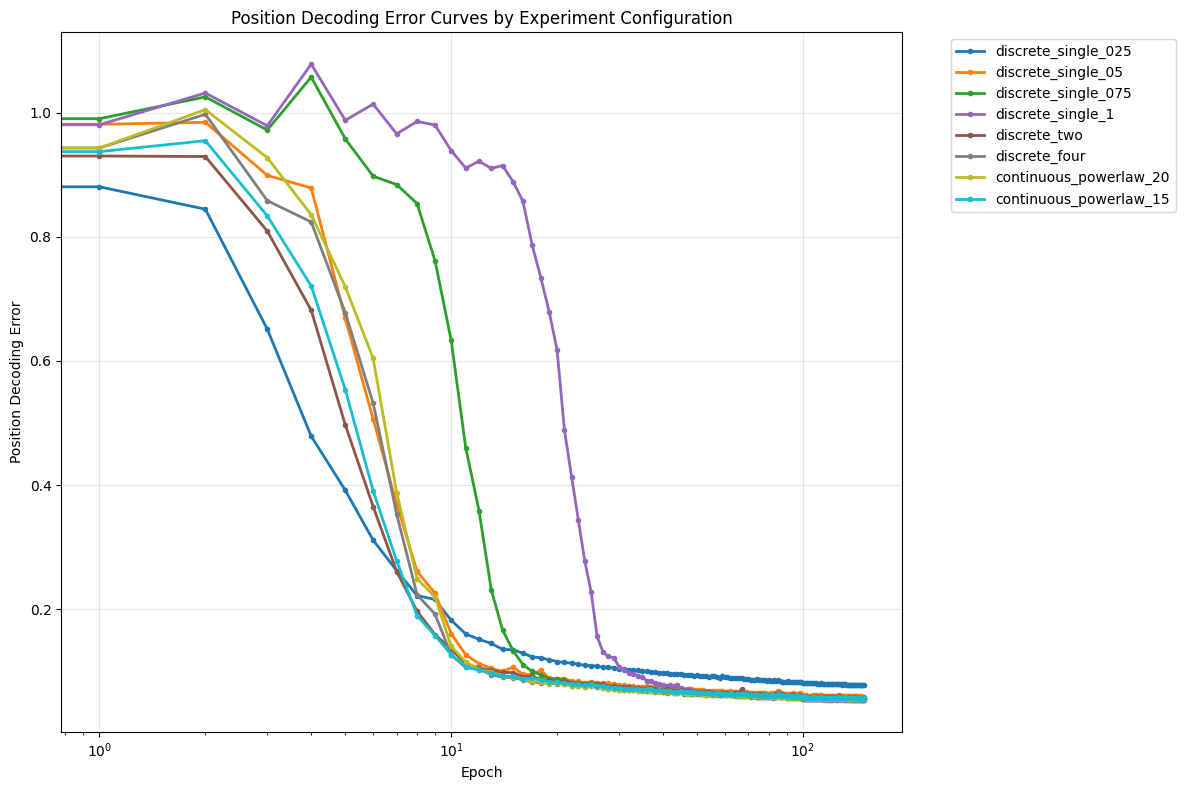

In [9]:
def plot_decoding_error_curves_by_experiment(
    models: Dict[str, Dict[int, Dict[str, Any]]],
    figsize: tuple = (12, 8),
    title: str = None,
    log_x: bool = True,
    log_y: bool = False,
    alpha_fill: float = 0.3,
) -> None:
    """
    Plot mean position decoding error curves across seeds for each experiment.

    Args:
        models: Dictionary from load_experiment_sweep
        figsize: Figure size
        title: Plot title (auto-generated if None)
        log_x: Use log scale on x-axis
        log_y: Use log scale on y-axis
        alpha_fill: Transparency for error bars
    """

    plt.figure(figsize=figsize)

    # Color palette for experiments
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

    for exp_idx, (exp_name, seeds) in enumerate(models.items()):
        # Collect decoding error curves from all seeds
        all_errors = []
        all_epochs = []

        for seed, seed_data in seeds.items():
            position_errors = seed_data.get("position_decoding_errors", None)
            if not position_errors:  # Skip if no position decoding data
                continue

            epochs = np.array(position_errors["epochs"])
            errors = np.array(position_errors["position_errors_epoch"])

            all_errors.append(errors)
            all_epochs.append(epochs)

        if not all_errors:
            print(f"Warning: No position decoding data found for experiment {exp_name}")
            continue

        # Find common epoch range (in case different seeds have different lengths)
        min_length = min(len(errors) for errors in all_errors)

        # Truncate all arrays to common length
        all_errors = [errors[:min_length] for errors in all_errors]
        epochs = all_epochs[0][:min_length]  # Use epochs from first seed

        # Convert to numpy array and compute statistics
        errors_array = np.array(all_errors)  # Shape: (n_seeds, n_epochs)

        mean_errors = np.mean(errors_array, axis=0)
        std_errors = np.std(errors_array, axis=0)

        # Plot mean with error bars
        color = colors[exp_idx]
        plt.plot(
            epochs,
            mean_errors,
            "o-",
            color=color,
            label=exp_name,
            linewidth=2,
            markersize=3,
        )
        plt.fill_between(
            epochs,
            mean_errors - std_errors,
            mean_errors + std_errors,
            alpha=alpha_fill,
            color=color,
        )

        print(
            f"{exp_name}: {len(all_errors)} seeds, final decoding error = {mean_errors[-1]:.4f} ± {std_errors[-1]:.4f}"
        )

    plt.xlabel("Epoch")
    plt.ylabel("Position Decoding Error")

    if title is None:
        title = "Position Decoding Error Curves by Experiment (Mean ± Std across seeds)"
    plt.title(title)

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)

    # Apply log scales
    if log_y:
        plt.yscale("log")
    if log_x:
        plt.xscale("log")

    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Usage example:
plot_decoding_error_curves_by_experiment(
    models,
    title="Position Decoding Error Curves by Experiment Configuration",
    log_x=True,
    log_y=False,
)

In [16]:
import plotly.graph_objects as go
import plotly.colors as pc
import numpy as np
from typing import Dict, Any


def hex_to_rgba(hex_color: str, alpha: float) -> str:
    """Convert hex color to rgba string with specified alpha."""
    # Remove '#' if present
    hex_color = hex_color.lstrip("#")
    # Convert hex to rgb
    rgb = tuple(int(hex_color[i : i + 2], 16) for i in (0, 2, 4))
    return f"rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, {alpha})"


def plot_decoding_error_curves_by_experiment_plotly(
    models: Dict[str, Dict[int, Dict[str, Any]]],
    title: str = None,
    log_x: bool = True,
    log_y: bool = False,
    alpha_fill: float = 0.3,
    width: int = 900,
    height: int = 600,
) -> None:
    """
    Plot interactive position decoding error curves across seeds for each experiment using Plotly.

    Args:
        models: Dictionary from load_experiment_sweep
        title: Plot title (auto-generated if None)
        log_x: Use log scale on x-axis
        log_y: Use log scale on y-axis
        alpha_fill: Transparency for error bands
        width: Figure width in pixels
        height: Figure height in pixels
    """

    fig = go.Figure()

    # Get color palette
    colors = (
        pc.qualitative.Plotly
    )  # or pc.qualitative.Set1, pc.qualitative.Dark24, etc.

    for exp_idx, (exp_name, seeds) in enumerate(models.items()):
        # Collect decoding error curves from all seeds
        all_errors = []
        all_epochs = []

        for seed, seed_data in seeds.items():
            position_errors = seed_data.get("position_decoding_errors", None)
            if not position_errors:  # Skip if no position decoding data
                continue

            epochs = np.array(position_errors["epochs"])
            errors = np.array(position_errors["position_errors_epoch"])

            all_errors.append(errors)
            all_epochs.append(epochs)

        if not all_errors:
            print(f"Warning: No position decoding data found for experiment {exp_name}")
            continue

        # Find common epoch range
        min_length = min(len(errors) for errors in all_errors)

        # Truncate all arrays to common length
        all_errors = [errors[:min_length] for errors in all_errors]
        epochs = all_epochs[0][:min_length]

        # Convert to numpy array and compute statistics
        errors_array = np.array(all_errors)  # Shape: (n_seeds, n_epochs)

        mean_errors = np.mean(errors_array, axis=0)
        std_errors = np.std(errors_array, axis=0)

        # Get color for this experiment
        color = colors[exp_idx % len(colors)]

        # Add error band (fill_between equivalent)
        fig.add_trace(
            go.Scatter(
                x=np.concatenate([epochs, epochs[::-1]]),
                y=np.concatenate(
                    [mean_errors + std_errors, (mean_errors - std_errors)[::-1]]
                ),
                fill="toself",
                fillcolor=hex_to_rgba(color, alpha_fill),
                line=dict(color="rgba(255,255,255,0)"),
                hoverinfo="skip",
                showlegend=False,
                name=f"{exp_name} ± std",
            )
        )

        # Add mean line
        fig.add_trace(
            go.Scatter(
                x=epochs,
                y=mean_errors,
                mode="lines+markers",
                name=exp_name,
                line=dict(color=color, width=2),
                marker=dict(size=4),
                hovertemplate=(
                    f"<b>{exp_name}</b><br>"
                    "Epoch: %{x}<br>"
                    "Mean Error: %{y:.4f}<br>"
                    f"Seeds: {len(all_errors)}<br>"
                    "<extra></extra>"
                ),
            )
        )

        print(
            f"{exp_name}: {len(all_errors)} seeds, final decoding error = {mean_errors[-1]:.4f} ± {std_errors[-1]:.4f}"
        )

    # Update layout
    if title is None:
        title = "Position Decoding Error Curves by Experiment (Mean ± Std across seeds)"

    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=16)),
        xaxis_title="Epoch",
        yaxis_title="Position Decoding Error",
        width=width,
        height=height,
        hovermode="x unified",
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=1.01),
        margin=dict(r=150),  # Add right margin for legend
    )

    # Apply log scales
    if log_x:
        fig.update_xaxes(type="log")
    if log_y:
        fig.update_yaxes(type="log")

    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")

    fig.show()


def plot_loss_curves_by_experiment_plotly(
    models: Dict[str, Dict[int, Dict[str, Any]]],
    loss_type: str = "train",  # "train" or "val"
    title: str = None,
    log_x: bool = True,
    log_y: bool = True,
    alpha_fill: float = 0.3,
    width: int = 900,
    height: int = 600,
) -> None:
    """
    Plot interactive training/validation loss curves across seeds for each experiment using Plotly.
    """

    fig = go.Figure()

    # Get color palette
    colors = pc.qualitative.Plotly

    for exp_idx, (exp_name, seeds) in enumerate(models.items()):
        # Collect loss curves from all seeds
        all_losses = []
        all_epochs = []

        for seed, seed_data in seeds.items():
            training_losses = seed_data["training_losses"]
            if not training_losses:  # Skip if no training data
                continue

            epochs = np.array(training_losses["epochs"])
            if loss_type == "train":
                losses = np.array(training_losses["train_losses"])
            else:  # val
                losses = np.array(training_losses["val_losses"])

            all_losses.append(losses)
            all_epochs.append(epochs)

        if not all_losses:
            print(f"Warning: No training data found for experiment {exp_name}")
            continue

        # Find common epoch range
        min_length = min(len(losses) for losses in all_losses)

        # Truncate all arrays to common length
        all_losses = [losses[:min_length] for losses in all_losses]
        epochs = all_epochs[0][:min_length]

        # Convert to numpy array and compute statistics
        losses_array = np.array(all_losses)

        mean_losses = np.mean(losses_array, axis=0)
        std_losses = np.std(losses_array, axis=0)

        # Get color for this experiment
        color = colors[exp_idx % len(colors)]

        # Add error band
        fig.add_trace(
            go.Scatter(
                x=np.concatenate([epochs, epochs[::-1]]),
                y=np.concatenate(
                    [mean_losses + std_losses, (mean_losses - std_losses)[::-1]]
                ),
                fill="toself",
                fillcolor=hex_to_rgba(color, alpha_fill),
                line=dict(color="rgba(255,255,255,0)"),
                hoverinfo="skip",
                showlegend=False,
                name=f"{exp_name} ± std",
            )
        )

        # Add mean line
        fig.add_trace(
            go.Scatter(
                x=epochs,
                y=mean_losses,
                mode="lines+markers",
                name=exp_name,
                line=dict(color=color, width=2),
                marker=dict(size=4),
                hovertemplate=(
                    f"<b>{exp_name}</b><br>"
                    "Epoch: %{x}<br>"
                    f"Mean {loss_type.capitalize()} Loss: %{{y:.4f}}<br>"
                    f"Seeds: {len(all_losses)}<br>"
                    "<extra></extra>"
                ),
            )
        )

        print(
            f"{exp_name}: {len(all_losses)} seeds, final {loss_type} loss = {mean_losses[-1]:.4f} ± {std_losses[-1]:.4f}"
        )

    # Update layout
    if title is None:
        title = f"{loss_type.capitalize()} Loss Curves by Experiment (Mean ± Std across seeds)"

    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=16)),
        xaxis_title="Epoch",
        yaxis_title=f"{loss_type.capitalize()} Loss",
        width=width,
        height=height,
        hovermode="x unified",
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=1.01),
        margin=dict(r=150),
    )

    # Apply log scales
    if log_x:
        fig.update_xaxes(type="log")
    if log_y:
        fig.update_yaxes(type="log")

    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")

    fig.show()

In [17]:
# Plot training loss curves (interactive)
plot_loss_curves_by_experiment_plotly(
    models,
    loss_type="train",
    title="Training Loss Curves by Experiment Configuration",
    log_x=True,
    log_y=False,
)

# Plot validation loss curves (interactive)
plot_loss_curves_by_experiment_plotly(
    models,
    loss_type="val",
    title="Validation Loss Curves by Experiment Configuration",
    log_x=True,
    log_y=False,
)

# Plot position decoding error curves (interactive)
plot_decoding_error_curves_by_experiment_plotly(
    models,
    title="Position Decoding Error Curves by Experiment Configuration",
    log_x=True,
    log_y=False,
)

discrete_single_025: 1 seeds, final train loss = 6.1011 ± 0.0000
discrete_single_05: 1 seeds, final train loss = 6.0708 ± 0.0000
discrete_single_075: 1 seeds, final train loss = 6.0599 ± 0.0000
discrete_single_1: 1 seeds, final train loss = 6.0579 ± 0.0000
discrete_two: 1 seeds, final train loss = 6.0639 ± 0.0000
discrete_four: 1 seeds, final train loss = 6.0589 ± 0.0000
continuous_powerlaw_20: 1 seeds, final train loss = 6.0600 ± 0.0000
continuous_powerlaw_15: 1 seeds, final train loss = 6.0621 ± 0.0000


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [24]:
import plotly.graph_objects as go
import plotly.colors as pc
import numpy as np
from typing import Dict, Any


def hex_to_rgba(hex_color: str, alpha: float) -> str:
    """Convert hex color to rgba string with specified alpha."""
    # Remove '#' if present
    hex_color = hex_color.lstrip("#")
    # Convert hex to rgb
    rgb = tuple(int(hex_color[i : i + 2], 16) for i in (0, 2, 4))
    return f"rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, {alpha})"


def plot_decoding_error_curves_by_experiment_plotly(
    models: Dict[str, Dict[int, Dict[str, Any]]],
    title: str = None,
    log_x: bool = True,
    log_y: bool = False,
    alpha_fill: float = 0.3,
    width: int = 900,
    height: int = 600,
    save_html: str = None,  # Add option to save as HTML
) -> go.Figure:  # Return figure object
    """
    Plot interactive position decoding error curves across seeds for each experiment using Plotly.
    """

    fig = go.Figure()

    # Get color palette
    colors = pc.qualitative.Plotly

    for exp_idx, (exp_name, seeds) in enumerate(models.items()):
        # Collect decoding error curves from all seeds
        all_errors = []
        all_epochs = []

        for seed, seed_data in seeds.items():
            position_errors = seed_data.get("position_decoding_errors", None)
            if not position_errors:  # Skip if no position decoding data
                continue

            epochs = np.array(position_errors["epochs"])
            errors = np.array(position_errors["position_errors_epoch"])

            all_errors.append(errors)
            all_epochs.append(epochs)

        if not all_errors:
            print(f"Warning: No position decoding data found for experiment {exp_name}")
            continue

        # Find common epoch range
        min_length = min(len(errors) for errors in all_errors)

        # Truncate all arrays to common length
        all_errors = [errors[:min_length] for errors in all_errors]
        epochs = all_epochs[0][:min_length]

        # Convert to numpy array and compute statistics
        errors_array = np.array(all_errors)

        mean_errors = np.mean(errors_array, axis=0)
        std_errors = np.std(errors_array, axis=0)

        # Get color for this experiment
        color = colors[exp_idx % len(colors)]

        # Add error band
        fig.add_trace(
            go.Scatter(
                x=np.concatenate([epochs, epochs[::-1]]),
                y=np.concatenate(
                    [mean_errors + std_errors, (mean_errors - std_errors)[::-1]]
                ),
                fill="toself",
                fillcolor=hex_to_rgba(color, alpha_fill),
                line=dict(color="rgba(255,255,255,0)"),
                hoverinfo="skip",
                showlegend=False,
                name=f"{exp_name} ± std",
            )
        )

        # Add mean line
        fig.add_trace(
            go.Scatter(
                x=epochs,
                y=mean_errors,
                mode="lines+markers",
                name=exp_name,
                line=dict(color=color, width=2),
                marker=dict(size=4),
                hovertemplate=(
                    f"<b>{exp_name}</b><br>"
                    "Epoch: %{x}<br>"
                    "Mean Error: %{y:.4f}<br>"
                    f"Seeds: {len(all_errors)}<br>"
                    "<extra></extra>"
                ),
            )
        )

        print(
            f"{exp_name}: {len(all_errors)} seeds, final decoding error = {mean_errors[-1]:.4f} ± {std_errors[-1]:.4f}"
        )

    # Update layout
    if title is None:
        title = "Position Decoding Error Curves by Experiment (Mean ± Std across seeds)"

    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=16)),
        xaxis_title="Epoch",
        yaxis_title="Position Decoding Error",
        width=width,
        height=height,
        hovermode="x unified",
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=1.01),
        margin=dict(r=150),
    )

    # Apply log scales
    if log_x:
        fig.update_xaxes(type="log")
    if log_y:
        fig.update_yaxes(type="log")

    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")

    # Show or save
    if save_html:
        fig.write_html(save_html)
        print(f"Plot saved as {save_html}")
    else:
        try:
            fig.show()
        except ValueError as e:
            print(f"Cannot display inline due to: {e}")
            print("Try installing nbformat>=4.2.0 or use save_html parameter")

    return fig


def plot_loss_curves_by_experiment_plotly(
    models: Dict[str, Dict[int, Dict[str, Any]]],
    loss_type: str = "train",
    title: str = None,
    log_x: bool = True,
    log_y: bool = True,
    alpha_fill: float = 0.3,
    width: int = 900,
    height: int = 600,
    save_html: str = None,
) -> go.Figure:
    """
    Plot interactive training/validation loss curves across seeds for each experiment using Plotly.
    """

    fig = go.Figure()

    # Get color palette
    colors = pc.qualitative.Plotly

    for exp_idx, (exp_name, seeds) in enumerate(models.items()):
        # Collect loss curves from all seeds
        all_losses = []
        all_epochs = []

        for seed, seed_data in seeds.items():
            training_losses = seed_data["training_losses"]
            if not training_losses:
                continue

            epochs = np.array(training_losses["epochs"])
            if loss_type == "train":
                losses = np.array(training_losses["train_losses"])
            else:
                losses = np.array(training_losses["val_losses"])

            all_losses.append(losses)
            all_epochs.append(epochs)

        if not all_losses:
            print(f"Warning: No training data found for experiment {exp_name}")
            continue

        # Find common epoch range
        min_length = min(len(losses) for losses in all_losses)

        # Truncate all arrays to common length
        all_losses = [losses[:min_length] for losses in all_losses]
        epochs = all_epochs[0][:min_length]

        # Convert to numpy array and compute statistics
        losses_array = np.array(all_losses)

        mean_losses = np.mean(losses_array, axis=0)
        std_losses = np.std(losses_array, axis=0)

        # Get color for this experiment
        color = colors[exp_idx % len(colors)]

        # Add error band
        fig.add_trace(
            go.Scatter(
                x=np.concatenate([epochs, epochs[::-1]]),
                y=np.concatenate(
                    [mean_losses + std_losses, (mean_losses - std_losses)[::-1]]
                ),
                fill="toself",
                fillcolor=hex_to_rgba(color, alpha_fill),
                line=dict(color="rgba(255,255,255,0)"),
                hoverinfo="skip",
                showlegend=False,
                name=f"{exp_name} ± std",
            )
        )

        # Add mean line
        fig.add_trace(
            go.Scatter(
                x=epochs,
                y=mean_losses,
                mode="lines+markers",
                name=exp_name,
                line=dict(color=color, width=2),
                marker=dict(size=4),
                hovertemplate=(
                    f"<b>{exp_name}</b><br>"
                    "Epoch: %{x}<br>"
                    f"Mean {loss_type.capitalize()} Loss: %{{y:.4f}}<br>"
                    f"Seeds: {len(all_losses)}<br>"
                    "<extra></extra>"
                ),
            )
        )

        print(
            f"{exp_name}: {len(all_losses)} seeds, final {loss_type} loss = {mean_losses[-1]:.4f} ± {std_losses[-1]:.4f}"
        )

    # Update layout
    if title is None:
        title = f"{loss_type.capitalize()} Loss Curves by Experiment (Mean ± Std across seeds)"

    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=16)),
        xaxis_title="Epoch",
        yaxis_title=f"{loss_type.capitalize()} Loss",
        width=width,
        height=height,
        hovermode="x unified",
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=1.01),
        margin=dict(r=150),
    )

    # Apply log scales
    if log_x:
        fig.update_xaxes(type="log")
    if log_y:
        fig.update_yaxes(type="log")

    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")

    # Show or save
    if save_html:
        fig.write_html(save_html)
        print(f"Plot saved as {save_html}")
    else:
        try:
            fig.show()
        except ValueError as e:
            print(f"Cannot display inline due to: {e}")
            print("Try installing nbformat>=4.2.0 or use save_html parameter")

    return fig

In [25]:
# Save plots as HTML files that you can open in browser
plot_loss_curves_by_experiment_plotly(
    models, loss_type="train", save_html="train_loss_curves.html"
)

plot_loss_curves_by_experiment_plotly(
    models, loss_type="val", save_html="val_loss_curves.html"
)

# plot_decoding_error_curves_by_experiment_plotly(
#     models, save_html="decoding_error_curves.html"
# )

discrete_single_025: 1 seeds, final train loss = 6.1011 ± 0.0000
discrete_single_05: 1 seeds, final train loss = 6.0708 ± 0.0000
discrete_single_075: 1 seeds, final train loss = 6.0599 ± 0.0000
discrete_single_1: 1 seeds, final train loss = 6.0579 ± 0.0000
discrete_two: 1 seeds, final train loss = 6.0639 ± 0.0000
discrete_four: 1 seeds, final train loss = 6.0589 ± 0.0000
continuous_powerlaw_20: 1 seeds, final train loss = 6.0600 ± 0.0000
continuous_powerlaw_15: 1 seeds, final train loss = 6.0621 ± 0.0000
Plot saved as train_loss_curves.html
discrete_single_025: 1 seeds, final val loss = 6.1011 ± 0.0000
discrete_single_05: 1 seeds, final val loss = 6.0703 ± 0.0000
discrete_single_075: 1 seeds, final val loss = 6.0594 ± 0.0000
discrete_single_1: 1 seeds, final val loss = 6.0575 ± 0.0000
discrete_two: 1 seeds, final val loss = 6.0634 ± 0.0000
discrete_four: 1 seeds, final val loss = 6.0585 ± 0.0000
continuous_powerlaw_20: 1 seeds, final val loss = 6.0595 ± 0.0000
continuous_powerlaw_15: 1

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'fill': 'toself',
              'fillcolor': 'rgba(99, 110, 250, 0.3)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(255,255,255,0)'},
              'name': 'discrete_single_025 ± std',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'oACQAIAAcABgAFAAQAAwACAAEAAAA='),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAwHqNGUAAAACgGywZQAAAAOB8BR' ... 'DgfAUZQAAAAKAbLBlAAAAAwHqNGUA='),
                    'dtype': 'f8'}},
             {'hovertemplate': ('<b>discrete_single_025</b><br>' ... 'br>Seeds: 1<br><extra></extra>'),
              'line': {'color': '#636EFA', 'width': 2},
              'marker': {'size': 4},
              'mode': 'lines+markers',
              'name': 'discrete_single_025',
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'CLAIwAjQCOAI8AkACRAJIAkwCUAA=='),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAwHqNGUAAAACgGywZQAAAAOB8BR' ... 'CqZxhAAAAAoFVnGEAAAAAAiGcYQA=='),
                    'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(239, 85, 59, 0.3)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(255,255,255,0)'},
              'name': 'discrete_single_05 ± std',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'oACQAIAAcABgAFAAQAAwACAAEAAAA='),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAYJuQGUAAAABA0S4ZQAAAAKCdCR' ... 'CgnQkZQAAAAEDRLhlAAAAAYJuQGUA='),
                    'dtype': 'f8'}},
             {'hovertemplate': ('<b>discrete_single_05</b><br>E' ... 'br>Seeds: 1<br><extra></extra>'),
              'line': {'color': '#EF553B', 'width': 2},
              'marker': {'size': 4},
              'mode': 'lines+markers',
              'name': 'discrete_single_05',
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'CLAIwAjQCOAI8AkACRAJIAkwCUAA=='),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAYJuQGUAAAABA0S4ZQAAAAKCdCR' ... 'CRSBhAAAAAIElIGEAAAAAg9EcYQA=='),
                    'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(0, 204, 150, 0.3)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(255,255,255,0)'},
              'name': 'discrete_single_075 ± std',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'oACQAIAAcABgAFAAQAAwACAAEAAAA='),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAA4BiSGUAAAACA6C8ZQAAAAECuCh' ... 'BArgoZQAAAAIDoLxlAAAAA4BiSGUA='),
                    'dtype': 'f8'}},
             {'hovertemplate': ('<b>discrete_single_075</b><br>' ... 'br>Seeds: 1<br><extra></extra>'),
              'line': {'color': '#00CC96', 'width': 2},
              'marker': {'size': 4},
              'mode': 'lines+markers',
              'name': 'discrete_single_075',
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'CLAIwAjQCOAI8AkACRAJIAkwCUAA=='),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAA4BiSGUAAAACA6C8ZQAAAAECuCh' ... 'BZPRhAAAAAAPc8GEAAAACAzjwYQA=='),
                    'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(171, 99, 250, 0.3)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(255,255,255,0)'},
              'name': 'discrete_single_1 ± std',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'oACQAIAAcABgAFAAQAAwACAAEAAAA='),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAA4PKSGUAAAADgczAZQAAAAMAGCx' ... 'DAB

In [27]:
plot_decoding_error_curves_by_experiment_plotly(
    models, save_html="decoding_error_curves.html", log_x=True, log_y=True
)

discrete_single_025: 1 seeds, final decoding error = 0.0770 ± 0.0000
discrete_single_05: 1 seeds, final decoding error = 0.0589 ± 0.0000
discrete_single_075: 1 seeds, final decoding error = 0.0542 ± 0.0000
discrete_single_1: 1 seeds, final decoding error = 0.0542 ± 0.0000
discrete_two: 1 seeds, final decoding error = 0.0568 ± 0.0000
discrete_four: 1 seeds, final decoding error = 0.0550 ± 0.0000
continuous_powerlaw_20: 1 seeds, final decoding error = 0.0550 ± 0.0000
continuous_powerlaw_15: 1 seeds, final decoding error = 0.0564 ± 0.0000
Plot saved as decoding_error_curves.html


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'fill': 'toself',
              'fillcolor': 'rgba(99, 110, 250, 0.3)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(255,255,255,0)'},
              'name': 'discrete_single_025 ± std',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'AKAAkACAAHAAYABQAEAAMAAgABAAAA'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAA4ETR7j8AAACg5y3sPwAAAKB2Bu' ... 'AAoHYG6z8AAACg5y3sPwAAAOBE0e4/'),
                    'dtype': 'f8'}},
             {'hovertemplate': ('<b>discrete_single_025</b><br>' ... 'br>Seeds: 1<br><extra></extra>'),
              'line': {'color': '#636EFA', 'width': 2},
              'marker': {'size': 4},
              'mode': 'lines+markers',
              'name': 'discrete_single_025',
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'CLAIwAjQCOAI8AkACRAJIAkwCUAJUA'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAA4ETR7j8AAACg5y3sPwAAAKB2Bu' ... 'AAYPjPsz8AAADAH+GzPwAAAIBrtbM/'),
                    'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(239, 85, 59, 0.3)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(255,255,255,0)'},
              'name': 'discrete_single_05 ± std',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'AKAAkACAAHAAYABQAEAAMAAgABAAAA'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAYHiu7j8AAACgtWbvPwAAAEB7ge' ... 'AAQHuB7z8AAACgtWbvPwAAAGB4ru4/'),
                    'dtype': 'f8'}},
             {'hovertemplate': ('<b>discrete_single_05</b><br>E' ... 'br>Seeds: 1<br><extra></extra>'),
              'line': {'color': '#EF553B', 'width': 2},
              'marker': {'size': 4},
              'mode': 'lines+markers',
              'name': 'discrete_single_05',
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'CLAIwAjQCOAI8AkACRAJIAkwCUAJUA'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAYHiu7j8AAACgtWbvPwAAAEB7ge' ... 'AAIMc+rj8AAABAKv+tPwAAAOA4Ja4/'),
                    'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(0, 204, 150, 0.3)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(255,255,255,0)'},
              'name': 'discrete_single_075 ± std',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'AKAAkACAAHAAYABQAEAAMAAgABAAAA'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAA4OGT7z8AAADAWbHvPwAAAIBtaP' ... 'AAgG1o8D8AAADAWbHvPwAAAODhk+8/'),
                    'dtype': 'f8'}},
             {'hovertemplate': ('<b>discrete_single_075</b><br>' ... 'br>Seeds: 1<br><extra></extra>'),
              'line': {'color': '#00CC96', 'width': 2},
              'marker': {'size': 4},
              'mode': 'lines+markers',
              'name': 'discrete_single_075',
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'CLAIwAjQCOAI8AkACRAJIAkwCUAJUA'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAA4OGT7z8AAADAWbHvPwAAAIBtaP' ... 'AAgOORqz8AAABgVY6rPwAAAGDMxas/'),
                    'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(171, 99, 250, 0.3)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(255,255,255,0)'},
              'name': 'discrete_single_1 ± std',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'AKAAkACAAHAAYABQAEAAMAAgABAAAA'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAIOKo7z8AAABA4mDvPwAAAIAcgv' ... 'AAg